In [2]:
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

In [ ]:
import time
import json
import re
from datetime import datetime, timedelta
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import undetected_chromedriver as uc
from bs4 import BeautifulSoup
import random

class LinkedInScraper:
    def __init__(self, email=None, password=None):
        """
        Initialize the LinkedIn scraper
        
        Args:
            email: LinkedIn email (optional - for logged in scraping)
            password: LinkedIn password (optional - for logged in scraping)
        """
        self.email = email
        self.password = password
        self.driver = None
        self.logged_in = False
        
    def setup_driver(self):
        """
        Set up undetected Chrome driver to avoid detection
        """
        options = uc.ChromeOptions()
        options.add_argument('--disable-blink-features=AutomationControlled')
        options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-gpu')
        
        # Optional: run headless
        # options.add_argument('--headless')
        
        self.driver = uc.Chrome(options=options)
        self.driver.implicitly_wait(10)
        
    def random_delay(self, min_seconds=1, max_seconds=3):
        """Add random delay to mimic human behavior"""
        time.sleep(random.uniform(min_seconds, max_seconds))
        
    def scroll_slowly(self, pixels=300):
        """Scroll slowly to mimic human behavior"""
        self.driver.execute_script(f"window.scrollBy(0, {pixels});")
        self.random_delay(0.5, 1)
        
    def login(self):
        """
        Login to LinkedIn if credentials are provided
        """
        if not self.email or not self.password:
            print("No credentials provided, continuing without login")
            return False
            
        try:
            self.driver.get("https://www.linkedin.com/login")
            self.random_delay(2, 4)
            
            # Enter email
            email_input = WebDriverWait(self.driver, 10).until(
                EC.presence_of_element_located((By.ID, "username"))
            )
            email_input.send_keys(self.email)
            self.random_delay(0.5, 1)
            
            # Enter password
            password_input = self.driver.find_element(By.ID, "password")
            password_input.send_keys(self.password)
            self.random_delay(0.5, 1)
            
            # Click login button
            login_button = self.driver.find_element(By.XPATH, "//button[@type='submit']")
            login_button.click()
            
            self.random_delay(3, 5)
            
            # Check if login was successful
            if "feed" in self.driver.current_url or "mynetwork" in self.driver.current_url:
                print("Login successful")
                self.logged_in = True
                return True
            else:
                print("Login may have failed - check for CAPTCHA or 2FA")
                return False
                
        except Exception as e:
            print(f"Login error: {e}")
            return False
    
    def get_greenhouse_job_date(self, job_url):
        """
        Extract job posting date from Greenhouse URL
        """
        try:
            self.driver.get(job_url)
            self.random_delay(2, 3)
            
            # Look for date in various possible locations
            date_patterns = [
                r'Posted on (\w+ \d+, \d{4})',
                r'(\d{4}-\d{2}-\d{2})',
                r'(\d{1,2}/\d{1,2}/\d{4})'
            ]
            
            page_source = self.driver.page_source
            soup = BeautifulSoup(page_source, 'html.parser')
            
            # Check meta tags
            meta_date = soup.find('meta', {'property': 'article:published_time'})
            if meta_date:
                date_str = meta_date.get('content', '')
                if date_str:
                    return datetime.fromisoformat(date_str.replace('Z', '+00:00'))
            
            # Search for date patterns in text
            text_content = soup.get_text()
            for pattern in date_patterns:
                match = re.search(pattern, text_content)
                if match:
                    date_str = match.group(1)
                    # Try to parse the date
                    for fmt in ['%B %d, %Y', '%Y-%m-%d', '%m/%d/%Y']:
                        try:
                            return datetime.strptime(date_str, fmt)
                        except:
                            continue
            
            print("Could not find job posting date")
            return None
            
        except Exception as e:
            print(f"Error getting job date: {e}")
            return None
    
    def search_linkedin_posts(self, company_name, keyword, start_date, end_date):
        """
        Search LinkedIn for posts containing keyword from company employees
        """
        results = []
        
        # Build search URL
        search_query = f'"{keyword}" "{company_name}"'
        encoded_query = search_query.replace(' ', '%20').replace('"', '%22')
        
        # Try different search approaches
        search_urls = [
            f"https://www.linkedin.com/search/results/content/?keywords={encoded_query}&origin=GLOBAL_SEARCH_HEADER",
            f"https://www.linkedin.com/search/results/all/?keywords={encoded_query}"
        ]
        
        for search_url in search_urls:
            try:
                self.driver.get(search_url)
                self.random_delay(3, 5)
                
                # Check for login wall
                if "login" in self.driver.current_url and not self.logged_in:
                    print("Hit login wall - results will be limited")
                    continue
                
                # Scroll to load more results
                for _ in range(3):  # Scroll 3 times
                    self.scroll_slowly(500)
                    self.random_delay(1, 2)
                
                # Parse results
                posts = self.driver.find_elements(By.CSS_SELECTOR, "[data-chameleon-result-urn]")
                
                for post in posts[:10]:  # Limit to first 10 to avoid detection
                    try:
                        # Extract post text
                        text_element = post.find_element(By.CSS_SELECTOR, ".break-words")
                        post_text = text_element.text
                        
                        # Check if it contains our keyword and company
                        if keyword.lower() in post_text.lower() and company_name.lower() in post_text.lower():
                            # Try to extract author and date
                            author_element = post.find_element(By.CSS_SELECTOR, ".app-aware-link span[dir='ltr']")
                            author_name = author_element.text if author_element else "Unknown"
                            
                            # Extract relative date (e.g., "2d", "1w")
                            date_element = post.find_element(By.CSS_SELECTOR, "time")
                            relative_date = date_element.text if date_element else "Unknown"
                            
                            # Try to get post URL
                            link_element = post.find_element(By.CSS_SELECTOR, "a[href*='/posts/']")
                            post_url = link_element.get_attribute('href') if link_element else ""
                            
                            results.append({
                                'author': author_name,
                                'text': post_text[:200] + "..." if len(post_text) > 200 else post_text,
                                'relative_date': relative_date,
                                'url': post_url
                            })
                            
                    except NoSuchElementException:
                        continue
                        
            except Exception as e:
                print(f"Error searching posts: {e}")
                
        return results
    
    def alternative_search_method(self, company_name, keyword):
        """
        Alternative method: Search via Google with site:linkedin.com
        """
        results = []
        
        # Use Google to search LinkedIn
        search_query = f'site:linkedin.com/posts "{keyword}" "{company_name}" "hiring"'
        google_url = f"https://www.google.com/search?q={search_query.replace(' ', '+')}"
        
        try:
            self.driver.get(google_url)
            self.random_delay(2, 3)
            
            # Get search results
            search_results = self.driver.find_elements(By.CSS_SELECTOR, "div.g")
            
            for result in search_results[:5]:  # Limit results
                try:
                    link = result.find_element(By.CSS_SELECTOR, "a")
                    url = link.get_attribute('href')
                    title = result.find_element(By.CSS_SELECTOR, "h3").text
                    snippet = result.find_element(By.CSS_SELECTOR, "span.aCOpRe").text
                    
                    if "linkedin.com" in url and keyword.lower() in snippet.lower():
                        results.append({
                            'title': title,
                            'snippet': snippet,
                            'url': url
                        })
                        
                except NoSuchElementException:
                    continue
                    
        except Exception as e:
            print(f"Error with Google search: {e}")
            
        return results
    
    def run_search(self, job_url, company_name="DoorDash", keyword="Hiring"):
        """
        Main method to run the search
        """
        try:
            self.setup_driver()
            
            # Get job posting date
            print("Fetching job posting date...")
            job_date = self.get_greenhouse_job_date(job_url)
            
            if not job_date:
                job_date = datetime.now()
                print("Using current date as fallback")
            
            # Calculate date range
            start_date = job_date - timedelta(days=30)
            end_date = job_date + timedelta(days=30)
            
            print(f"\nSearching for '{keyword}' posts from {company_name}")
            print(f"Date range: {start_date.date()} to {end_date.date()}")
            
            # Try to login if credentials provided
            if self.email and self.password:
                print("\nAttempting to login...")
                self.login()
            
            # Method 1: Direct LinkedIn search
            print("\nSearching LinkedIn directly...")
            linkedin_results = self.search_linkedin_posts(company_name, keyword, start_date, end_date)
            
            # Method 2: Google search
            print("\nSearching via Google...")
            google_results = self.alternative_search_method(company_name, keyword)
            
            # Display results
            print("\n" + "="*80)
            print("RESULTS FROM LINKEDIN SEARCH:")
            print("="*80)
            
            if linkedin_results:
                for i, result in enumerate(linkedin_results, 1):
                    print(f"\n{i}. {result['author']} ({result['relative_date']})")
                    print(f"   {result['text']}")
                    print(f"   URL: {result['url']}")
            else:
                print("No results found on LinkedIn")
            
            print("\n" + "="*80)
            print("RESULTS FROM GOOGLE SEARCH:")
            print("="*80)
            
            if google_results:
                for i, result in enumerate(google_results, 1):
                    print(f"\n{i}. {result['title']}")
                    print(f"   {result['snippet']}")
                    print(f"   URL: {result['url']}")
            else:
                print("No results found via Google")
                
        except Exception as e:
            print(f"Error during search: {e}")
            
        finally:
            if self.driver:
                self.driver.quit()


def main():
    # Option 1: Without login (limited results)
    scraper = LinkedInScraper()
    
    # Option 2: With login (better results but risk of account restrictions)
    # scraper = LinkedInScraper(email="your_email@example.com", password="your_password")
    
    job_url = "https://job-boards.greenhouse.io/doordashusa/jobs/6330949"
    
    print("Starting LinkedIn scraper...")
    print("Note: This approach has limitations:")
    print("- LinkedIn actively blocks scrapers")
    print("- You may encounter CAPTCHAs")
    print("- Results will be limited without login")
    print("- Logged-in scraping risks account restrictions")
    print("\nProceed with caution!")
    print("-" * 80)
    
    scraper.run_search(job_url, company_name="DoorDash", keyword="Hiring")


if __name__ == "__main__":
    main()

In [ ]:
import requests
from datetime import datetime, timedelta
from urllib.parse import quote
import os
from bs4 import BeautifulSoup
import time

class LinkedInJobSearch:
    def __init__(self, access_token):
        """
        Initialize the LinkedIn API client
        
        Args:
            access_token: LinkedIn OAuth 2.0 access token
        """
        self.access_token = access_token
        self.base_url = "https://api.linkedin.com/v2"
        self.headers = {
            "Authorization": f"Bearer {self.access_token}",
            "Content-Type": "application/json",
            "X-Restli-Protocol-Version": "2.0.0"
        }
    
    def get_greenhouse_job_posting_date(self, job_url):
        """
        Extract the job posting date from a Greenhouse job URL
        
        Args:
            job_url: The Greenhouse job URL
            
        Returns:
            datetime object of the posting date or None if not found
        """
        try:
            response = requests.get(job_url)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Look for posting date in various possible locations
            # Greenhouse might store this in meta tags or specific divs
            date_selectors = [
                'meta[property="article:published_time"]',
                'meta[name="publish_date"]',
                'time[datetime]',
                '.posting-date',
                '.date-posted'
            ]
            
            for selector in date_selectors:
                element = soup.select_one(selector)
                if element:
                    if element.name == 'meta':
                        date_str = element.get('content')
                    elif element.name == 'time':
                        date_str = element.get('datetime')
                    else:
                        date_str = element.text.strip()
                    
                    if date_str:
                        # Try to parse the date
                        for fmt in ['%Y-%m-%d', '%Y-%m-%dT%H:%M:%S', '%B %d, %Y']:
                            try:
                                return datetime.strptime(date_str.split('T')[0], fmt)
                            except:
                                continue
            
            print("Warning: Could not find posting date on the page")
            return None
            
        except Exception as e:
            print(f"Error fetching job posting: {e}")
            return None
    
    def search_people_posts(self, company_name, keyword, start_date, end_date):
        """
        Search for LinkedIn posts from people at a specific company containing a keyword
        
        Args:
            company_name: Name of the company (e.g., "DoorDash")
            keyword: Keyword to search for in posts (e.g., "Hiring")
            start_date: Start date for the search range
            end_date: End date for the search range
            
        Returns:
            List of posts matching the criteria
        """
        # Note: LinkedIn's public API has limitations on search functionality
        # You might need to use the LinkedIn Marketing API or Sales Navigator API
        # for more advanced search capabilities
        
        results = []
        
        # First, find the company ID
        company_id = self.get_company_id(company_name)
        if not company_id:
            print(f"Could not find company ID for {company_name}")
            return results
        
        # Search for posts
        # This is a simplified example - actual implementation depends on API access level
        search_url = f"{self.base_url}/ugcPosts"
        
        params = {
            "q": "authors",
            "authors": f"List(urn:li:organization:{company_id})",
            "sortBy": "CREATED",
            "count": 50
        }
        
        try:
            response = requests.get(search_url, headers=self.headers, params=params)
            response.raise_for_status()
            
            posts = response.json().get('elements', [])
            
            for post in posts:
                # Check if post contains the keyword and is within date range
                post_text = post.get('specificContent', {}).get('com.linkedin.ugc.ShareContent', {}).get('shareCommentary', {}).get('text', '')
                created_time = post.get('created', {}).get('time', 0) / 1000  # Convert from milliseconds
                post_date = datetime.fromtimestamp(created_time)
                
                if (keyword.lower() in post_text.lower() and 
                    start_date <= post_date <= end_date):
                    
                    # Get author information
                    author_urn = post.get('author')
                    author_info = self.get_author_info(author_urn)
                    
                    results.append({
                        'author': author_info,
                        'post_text': post_text,
                        'post_date': post_date,
                        'post_url': f"https://www.linkedin.com/feed/update/{post.get('id')}"
                    })
            
        except requests.exceptions.RequestException as e:
            print(f"Error searching posts: {e}")
        
        return results
    
    def get_company_id(self, company_name):
        """
        Get LinkedIn company ID from company name
        
        Args:
            company_name: Name of the company
            
        Returns:
            Company ID or None if not found
        """
        search_url = f"{self.base_url}/organizationLookup"
        params = {"q": "vanityName", "vanityName": company_name.lower().replace(" ", "")}
        
        try:
            response = requests.get(search_url, headers=self.headers, params=params)
            response.raise_for_status()
            
            data = response.json()
            if data.get('elements'):
                return data['elements'][0].get('id')
                
        except Exception as e:
            print(f"Error finding company: {e}")
        
        return None
    
    def get_author_info(self, author_urn):
        """
        Get author information from URN
        
        Args:
            author_urn: LinkedIn URN of the author
            
        Returns:
            Dictionary with author information
        """
        # Extract ID from URN
        author_id = author_urn.split(':')[-1]
        
        # Note: Getting full profile information requires additional permissions
        # This is a simplified version
        return {
            'id': author_id,
            'urn': author_urn,
            'profile_url': f"https://www.linkedin.com/in/{author_id}"
        }
    
    def search_hiring_posts_near_job_date(self, job_url, company_name="DoorDash", keyword="Hiring", days_range=30):
        """
        Main function to search for hiring posts within a date range of a job posting
        
        Args:
            job_url: Greenhouse job URL
            company_name: Company to search for
            keyword: Keyword to search in posts
            days_range: Number of days before/after job posting to search
            
        Returns:
            List of relevant posts
        """
        # Get job posting date
        job_date = self.get_greenhouse_job_posting_date(job_url)
        
        if not job_date:
            # If we can't find the date, use current date as fallback
            print("Using current date as fallback")
            job_date = datetime.now()
        
        # Calculate date range
        start_date = job_date - timedelta(days=days_range)
        end_date = job_date + timedelta(days=days_range)
        
        print(f"Searching for '{keyword}' posts from {company_name} employees")
        print(f"Date range: {start_date.date()} to {end_date.date()}")
        
        # Search for posts
        results = self.search_people_posts(company_name, keyword, start_date, end_date)
        
        return results


def main():
    # LinkedIn OAuth 2.0 access token
    # You need to obtain this through LinkedIn's OAuth flow
    # See: https://docs.microsoft.com/en-us/linkedin/shared/authentication/authorization-code-flow
    ACCESS_TOKEN = os.environ.get('LINKEDIN_ACCESS_TOKEN', 'YOUR_ACCESS_TOKEN_HERE')
    
    if ACCESS_TOKEN == 'YOUR_ACCESS_TOKEN_HERE':
        print("Please set your LinkedIn access token in the LINKEDIN_ACCESS_TOKEN environment variable")
        print("You can obtain an access token by following LinkedIn's OAuth 2.0 flow")
        return
    
    # Initialize the search client
    searcher = LinkedInJobSearch(ACCESS_TOKEN)
    
    # Job URL to analyze
    job_url = "https://job-boards.greenhouse.io/doordashusa/jobs/6330949"
    
    # Search for hiring posts
    results = searcher.search_hiring_posts_near_job_date(
        job_url=job_url,
        company_name="DoorDash",
        keyword="Hiring",
        days_range=30
    )
    
    # Display results
    print(f"\nFound {len(results)} relevant posts:")
    print("-" * 80)
    
    for i, post in enumerate(results, 1):
        print(f"\nPost {i}:")
        print(f"Author: {post['author']['profile_url']}")
        print(f"Date: {post['post_date'].strftime('%Y-%m-%d %H:%M')}")
        print(f"Text: {post['post_text'][:200]}..." if len(post['post_text']) > 200 else f"Text: {post['post_text']}")
        print(f"URL: {post['post_url']}")
        print("-" * 80)


if __name__ == "__main__":
    main()

**2**


0.05474249954177424


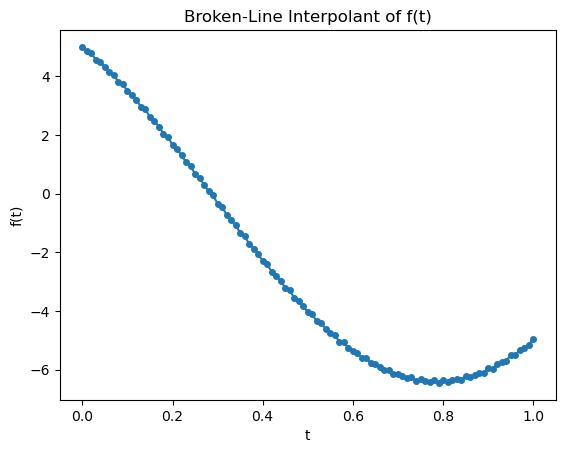

Minimum absolute value of f: 0.05474249954177424
v(t) coefficients: [ 22.4704284  -17.2699696  -15.11278224   5.14716134]
       3         2
22.47 x - 17.27 x - 15.11 x + 5.147


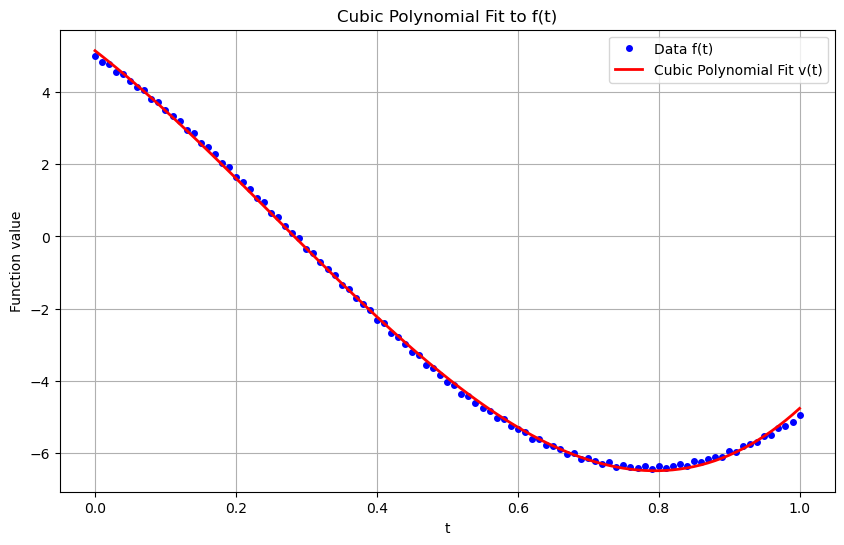

In [24]:

t = np.arange(0, 1.01, 0.01)  # 101 points from 0 to 1 in steps of 0.01

f = 0.05 * np.sin(1000 * t) + 5 * np.cos(np.pi * t) - 4 * np.sin(np.pi * t)
f_min = np.sqrt(np.min(f*f))
print(f_min)
plt.figure()
plt.plot(t, f, 'o-', markersize=4)
plt.title('Broken-Line Interpolant of f(t)')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.show()


print("Minimum absolute value of f:", f_min)

coeffs = np.polyfit(t, f, 3)
v = np.poly1d(coeffs)
print(f"v(t) coefficients: {coeffs}")
print(f"{v}")

# Evaluate the fitted polynomial at each t value.
v_fit = v(t)

# Plot the original data and the fitted polynomial.
plt.figure(figsize=(10, 6))
plt.plot(t, f, 'bo', markersize=4, label='Data f(t)')
plt.plot(t, v_fit, 'r-', linewidth=2, label='Cubic Polynomial Fit v(t)')
plt.xlabel('t')
plt.ylabel('Function value')
plt.title('Cubic Polynomial Fit to f(t)')
plt.legend()
plt.grid(True)
plt.show()


$$
\text{The resulting graph appears to have two local extrema, so an } n=3 \text{ polynomial is chosen.} \\
$$
$$
v(t) = 22.4704284\,t^3 - 17.2699696\,t^2 - 15.11278224\,t + 5.14716134.
$$


**4a**


Note that u(t) grows exponentially so fitting u(t) with linear methods is not ideal, with v(t):


**4b**
$$
\text{Taking logarithms: } v(t) = \ln u(t) = \ln \gamma_1 + \gamma_2 t.
$$

$$
\beta_0 = \ln \gamma_1 \quad \text{and} \quad \beta_1 = \gamma_2,
$$

$$
\text{so the linear model is } b_i = \beta_0 + \beta_1 t_i, \quad \text{with } b_i = \ln z_i.
$$

$$
\textbf{Given data: } (t_1,b_1) = (0,0.1),\quad (t_2,b_2) = (1,0.9),\quad (t_3,b_3) = (2,2).
$$

$$
\text{Set up the design matrix and data vector: }
X = \begin{pmatrix}
1 & 0 \\
1 & 1 \\
1 & 2
\end{pmatrix}, \quad
\mathbf{b} = \begin{pmatrix}
0.1 \\ 0.9 \\ 2
\end{pmatrix}.
$$

$$
\text{The normal equations are } X^T X\,\boldsymbol{\beta} = X^T \mathbf{b}.
$$

$$
X^T X = \begin{pmatrix}
1 & 1 & 1 \\
0 & 1 & 2
\end{pmatrix}
\begin{pmatrix}
1 & 0 \\
1 & 1 \\
1 & 2
\end{pmatrix}
=
\begin{pmatrix}
3 & 3 \\
3 & 5
\end{pmatrix}.
$$

$$
X^T \mathbf{b} = \begin{pmatrix}
1 & 1 & 1 \\
0 & 1 & 2
\end{pmatrix}
\begin{pmatrix}
0.1 \\ 0.9 \\ 2
\end{pmatrix}
=
\begin{pmatrix}
0.1 + 0.9 + 2 \\
0\cdot0.1 + 1\cdot0.9 + 2\cdot2
\end{pmatrix}
=
\begin{pmatrix}
3 \\ 4.9
\end{pmatrix}.
$$

$$
\text{Thus, the system is: }
\begin{pmatrix}
3 & 3 \\
3 & 5
\end{pmatrix}
\begin{pmatrix}
\beta_0 \\ \beta_1
\end{pmatrix}
=
\begin{pmatrix}
3 \\ 4.9
\end{pmatrix}.
$$

$$
\text{Writing the equations explicitly: }
\begin{aligned}
3\beta_0 + 3\beta_1 &= 3, \\
3\beta_0 + 5\beta_1 &= 4.9.
\end{aligned}
$$

$$
\text{Subtracting the first from the second: } 2\beta_1 = 1.9 \quad \Longrightarrow \quad \beta_1 = 0.95.
$$

$$
\text{Then, } \beta_0 = \frac{3 - 3\beta_1}{3} = \frac{3 - 2.85}{3} = \frac{0.15}{3} = 0.05.
$$

$$
\text{Recall } \beta_0 = \ln \gamma_1 \text{ and } \beta_1 = \gamma_2, \text{ so: }
$$

$$
\gamma_1 = \exp(0.05) \approx 1.0513, \quad \gamma_2 \approx 0.95.
$$

$$
\textbf{The final fitted model is: } u(t) = 1.0513\, \exp(0.95\,t).
$$

**5b**
$$
\[
\begin{aligned}
\kappa\bigl((A^T A)^{-1} A^T\bigr)
&= \bigl\|(A^T A)^{-1} A^T\bigr\|\,
   \bigl\|\bigl((A^T A)^{-1} A^T\bigr)^\dagger\bigr\| \\[6pt]
&= \bigl\|(A^T A)^{-1} A^T\bigr\|\,
   \bigl\|(A^T)^\dagger\,\bigl((A^T A)^{-1}\bigr)^\dagger\bigr\|
   \quad\text{(since \((BC)^\dagger = C^\dagger B^\dagger\))}\\[6pt]
&= \bigl\|(A^T A)^{-1}\bigr\|\;\|A^T\|\;\bigl\|(A^T)^\dagger\bigr\|\;
   \bigl\|\bigl((A^T A)^{-1}\bigr)^\dagger\bigr\| \\[4pt]
&=\bigl\|(A^T A)^{-1}\bigr\|\;\|A\|\;\bigl\|A^\dagger\bigr\|\;
   \bigl\|\bigl((A^T A)^{-1}\bigr)^\dagger\bigr\|
   \quad\text{(using }\|A^T\|=\|A\|\text{, etc.)}\\[6pt]
&= \bigl\|(A^T A)^{-1}\bigr\|\;\bigl\|(A^T A)\bigr\|
   \quad\text{(since \(((A^T A)^{-1})^\dagger = (A^T A)\) when \(A\) is full rank)}\\[6pt]
&= \kappa(A^T A).
\end{aligned}
\]
$$
The following hidden step is avoiding the calculation of $(A^T A)$, since this product is what blows the condition number up to $\kappa(A^T A)$.
$$
\[
\begin{aligned}
\kappa\bigl(R^{-1}Q^T\bigr)
&= \bigl\|R^{-1}Q^T\bigr\|
   \;\bigl\|\bigl(R^{-1}Q^T\bigr)^\dagger\bigr\| \\[4pt]
&= \bigl\|R^{-1}\bigr\|\;\bigl\|Q^T\bigr\|
   \;\bigl\|\bigl(Q^T\bigr)^\dagger\bigr\|\;\bigl\|\bigl(R^{-1}\bigr)^\dagger\bigr\|
   \quad\text{(again using \((BC)^\dagger = C^\dagger B^\dagger\))}\\[4pt]
&= \bigl\|R^{-1}\bigr\|\;\bigl\|(R^{-1})^\dagger\bigr\|
   \quad\text{(because \(Q\) is orthonormal, so \(\|Q\|=1\), etc.)}\\[4pt]
&= \kappa(R) \;=\; \kappa(A).
\end{aligned}
\]
$$

**6**
$$
\begin{array}{l}
\textbf{(a) Statement:} \quad
A = Q\begin{pmatrix} R \\ 0 \end{pmatrix}, \quad
r_{ii} \neq 0\ (i=1,\dots,n)
\iff A \text{ has full column rank } n. \\[1em]
\textbf{Proof:} \\[0.5em]
\underline{\text{Forward } (\Rightarrow):} \quad \text{Assume } r_{ii}\neq0. \\[0.5em]
\quad \bullet\ R \text{ is invertible (upper triangular with nonzero diagonal).} \\[0.5em]
\quad \bullet\ \operatorname{rank}\!\Bigl(\begin{pmatrix} R \\ 0 \end{pmatrix}\Bigr)
=\operatorname{rank}(R)=n. \\[0.5em]
\quad \bullet\ Q \text{ is orthogonal } \implies \operatorname{rank}(A)=n. \\[1em]
\underline{\text{Converse } (\Leftarrow):} \quad \text{Assume } A \text{ has full column rank } n. \\[0.5em]
\quad \bullet\ \operatorname{rank}(A)=\operatorname{rank}\!\Bigl(\begin{pmatrix} R \\ 0 \end{pmatrix}\Bigr)
=\operatorname{rank}(R)=n. \\[0.5em]
\quad \bullet\ \text{Thus, } R \text{ must have } n \text{ nonzero diagonal entries.} \\[2em]
\textbf{(b) Statement:} \quad
A = QR, \quad r_{ii}\neq0 \iff A \text{ has full column rank } n. \\[1em]
\textbf{Proof:} \\[0.5em]
\underline{\text{Forward } (\Rightarrow):} \quad \text{Assume } r_{ii}\neq0. \\[0.5em]
\quad \bullet\ R \text{ is invertible and } Q \text{ has orthonormal columns,}\\[0.5em]
\quad \quad \implies \operatorname{rank}(A)=\operatorname{rank}(R)=n. \\[1em]
\underline{\text{Converse } (\Leftarrow):} \quad \text{Assume } A \text{ has full column rank } n. \\[0.5em]
\quad \bullet\ \operatorname{rank}(A)=\operatorname{rank}(R)=n, \\[0.5em]
\quad \bullet\ \text{so } R \text{ has } n \text{ nonzero diagonal entries.}
\end{array}
$$


**7**
$$
\begin{array}{rcl}
\textbf{Given:} & \quad & \mathbf{v}_1 = \begin{pmatrix} a \\ c \end{pmatrix},\quad \mathbf{v}_2 = \begin{pmatrix} b \\ d \end{pmatrix}. \\[1em]
\textbf{Step 1:} && \mathbf{u}_1 = \mathbf{v}_1,\quad \|\mathbf{u}_1\| = \sqrt{a^2+c^2}, \\[1em]
&& \mathbf{q}_1 = \frac{1}{\sqrt{a^2+c^2}}\begin{pmatrix} a \\ c \end{pmatrix}. \\[1em]
\textbf{Step 2:} && \text{proj}_{\mathbf{q}_1}(\mathbf{v}_2)=\frac{ab+cd}{a^2+c^2}\begin{pmatrix} a \\ c \end{pmatrix}, \\[1em]
&& \mathbf{u}_2 = \mathbf{v}_2 - \text{proj}_{\mathbf{q}_1}(\mathbf{v}_2)
=\begin{pmatrix} b-\frac{(ab+cd)a}{a^2+c^2} \\[1mm] d-\frac{(ab+cd)c}{a^2+c^2} \end{pmatrix}, \\[1em]
&& \|\mathbf{u}_2\| = \frac{|ad-bc|}{\sqrt{a^2+c^2}}, \\[1em]
&& \mathbf{q}_2 = \frac{\mathbf{u}_2}{\|\mathbf{u}_2\|}
=\begin{pmatrix} \frac{c(-ad+bc)}{\sqrt{a^2+c^2}\;|ad-bc|} \\[1mm] \frac{a(ad-bc)}{\sqrt{a^2+c^2}\;|ad-bc|} \end{pmatrix}. \\[1em]
\textbf{Matrix } Q: && Q = \begin{pmatrix}
\displaystyle \frac{a}{\sqrt{a^2+c^2}} & \displaystyle \frac{c(-ad+bc)}{\sqrt{a^2+c^2}\;|ad-bc|} \\[1em]
\displaystyle \frac{c}{\sqrt{a^2+c^2}} & \displaystyle \frac{a(ad-bc)}{\sqrt{a^2+c^2}\;|ad-bc|}
\end{pmatrix}. \\[1em]
\textbf{Matrix } R: && R = \begin{pmatrix}
\sqrt{a^2+c^2} & \displaystyle \frac{ab+cd}{\sqrt{a^2+c^2}} \\[1em]
0 & \displaystyle \frac{|ad-bc|}{\sqrt{a^2+c^2}}
\end{pmatrix}. \\[1em]
&& \begin{pmatrix} \mathbf{v}_1 & \mathbf{v}_2 \end{pmatrix} = Q\,R.
\end{array}
$$


**9a**

$$
\begin{aligned}
P^T P &= (I - 2\,u\,u^T)^T (I - 2\,u\,u^T) \\
      &= (I - 2\,u\,u^T)(I - 2\,u\,u^T) \quad\text{(since } I-2uu^T \text{ is symmetric)}\\[1em]
      &= I - 2\,u\,u^T - 2\,u\,u^T + 4\,u\,u^T\,u\,u^T \\[1em]
      &= I - 4\,u\,u^T + 4\,u\,(u^T u)\,u^T \\[1em]
      &= I - 4\,u\,u^T + 4\,u\,u^T \quad\text{(if } \|u\|_2 = 1 \text{ so that } u^T u = 1\text{)}\\[1em]
      &= I. \\[1em]
\Longrightarrow\quad P^T = P^{-1} \quad\Longrightarrow\quad P \text{ is orthogonal.}
\end{aligned}
$$


**C8**

**9a**
$$
\text{Let } A = U \Sigma V^T \text{ be the SVD of } A. \text{ Then, }
A^T A = V \Sigma^T \Sigma V^T.
$$

$$
\text{For any } x \in \mathbb{R}^n \text{ with } \|x\| = 1,\quad
x^T (A^T A) x = \|\Sigma V^T x\|^2 > 0.
$$

$$
\text{Thus, } A^T A \text{ is positive definite (and non-singular).}
$$
**9b**
$$
\text{Let } B = A^T A. \text{ Since } B \text{ is symmetric, } B^{-1} \text{ is symmetric.}
$$

$$
\text{Moreover, } \bigl[A(A^TA)^{-1}A^T\bigr]^T = A(A^TA)^{-1}A^T,
$$

$$
\text{so the projection matrix } A(A^TA)^{-1}A^T \text{ is symmetric.}
$$
**9c**
$$
\begin{aligned}
& \text{Given } A \in \mathbb{R}^{m \times n} \text{ with } \operatorname{rank}(A)=n,\ m>n, \\
& \text{consider the least squares problem } \min_{\mathbf{x}} \|\mathbf{b} - A\mathbf{x}\|_2. \\[0.5em]
& \textbf{Normal Equations:} \quad A^TA\,\mathbf{x} = A^T\mathbf{b} \Longrightarrow
\mathbf{x} = (A^TA)^{-1}A^T\mathbf{b}. \\[0.5em]
& \textbf{Projection:} \quad A\mathbf{x} = A(A^TA)^{-1}A^T\mathbf{b} \triangleq P\mathbf{b}, \\
& \quad \text{and the residual } \mathbf{r} = \mathbf{b} - A\mathbf{x} = (I-P)\mathbf{b}, \\
& \quad \therefore \boxed{\mathbf{r} = \Bigl(I-A(A^TA)^{-1}A^T\Bigr)\mathbf{b}}.
\end{aligned}
$$

**9d**
$$
\begin{aligned}
& \text{Replace } \mathbf{b} \text{ with } \hat{\mathbf{b}} = \mathbf{b} + \alpha \mathbf{r}. \\[0.5em]
& \text{Since } \mathbf{r} \perp \operatorname{Col}(A) \text{ (i.e., } A^T\mathbf{r}=0\text{),} \\
& \quad \min_{\mathbf{x}} \|A\mathbf{x}-\hat{\mathbf{b}}\|_2
=\min_{\mathbf{x}} \|A\mathbf{x}-(\mathbf{b}+\alpha\mathbf{r})\|_2, \\[0.5em]
& \text{and } A^TA\,\mathbf{x} = A^T(\mathbf{b}+\alpha\mathbf{r})
=A^T\mathbf{b}, \\[0.5em]
& \quad \text{thus } \boxed{\mathbf{x} = (A^TA)^{-1}A^T\mathbf{b}\quad \forall\,\alpha\in\mathbb{R}}.
\end{aligned}
$$


**10a**

$$
\begin{aligned}
\kappa_{2}(A) &= \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)}, \quad
\kappa_{2}(A^{T}A + \gamma I) = \frac{\sigma_{\max}^2 + \gamma}{\sigma_{\min}^2 + \gamma}, \\
\text{so } \kappa_{2}^2(A) &\ge \kappa_{2}(A^{T}A + \gamma I) \\
\iff \left(\frac{\sigma_{\max}}{\sigma_{\min}}\right)^2 &\ge \frac{\sigma_{\max}^2 + \gamma}{\sigma_{\min}^2 + \gamma}.
\end{aligned}
$$

$$
\begin{aligned}
\text{Cross-multiply: } \quad & \sigma_{\max}^2(\sigma_{\min}^2+\gamma) \ge \sigma_{\min}^2(\sigma_{\max}^2+\gamma), \\
\text{which simplifies to } \quad & \sigma_{\max}^2\,\gamma \ge \sigma_{\min}^2\,\gamma \\
\implies \quad & \sigma_{\max}^2 \ge \sigma_{\min}^2,
\end{aligned}
$$

**10b**

$$
\begin{aligned}
\text{The regularized system } (A^{T}A + \gamma I)\mathbf{x}_{\gamma} &= A^{T}\mathbf{b}, \\
\text{is equivalent to } \quad \min_{\mathbf{x}} \Biggl\| \begin{pmatrix} A \\ \sqrt{\gamma}\,I \end{pmatrix}\mathbf{x} - \begin{pmatrix} \mathbf{b} \\ \mathbf{0} \end{pmatrix} \Biggr\|_2.
\end{aligned}
$$

$$
\begin{aligned}
\text{Proof: } \quad \|\mathbf{b}-A\mathbf{x}\|_2^2+\gamma\|\mathbf{x}\|_2^2
= \Biggl\| \begin{pmatrix} A \\ \sqrt{\gamma}\,I \end{pmatrix}\mathbf{x} - \begin{pmatrix} \mathbf{b} \\ \mathbf{0} \end{pmatrix} \Biggr\|_2^2.
\end{aligned}
$$

**10c**
$$
\begin{aligned}
\text{We prove } \|\mathbf{x}_{\gamma}\|_2 \le \|\mathbf{x}\|_2. \\
\text{Since } \mathbf{x}_{\gamma} &\text{ minimizes } \|\mathbf{b}-A\mathbf{x}\|_2^2+\gamma\|\mathbf{x}\|_2^2, \\
\text{and for the unregularized solution } \mathbf{x}, &\quad \|\mathbf{b}-A\mathbf{x}\|_2^2 \le \|\mathbf{b}-A\mathbf{x}_{\gamma}\|_2^2, \\
\text{adding } \gamma\|\mathbf{x}_{\gamma}\|_2^2 \text{ to both sides yields} \\
\|\mathbf{b}-A\mathbf{x}\|_2^2+\gamma\|\mathbf{x}_{\gamma}\|_2^2
&\le \|\mathbf{b}-A\mathbf{x}_{\gamma}\|_2^2+\gamma\|\mathbf{x}_{\gamma}\|_2^2, \\
\text{and by the minimality of } \mathbf{x}_{\gamma}, \quad
\|\mathbf{b}-A\mathbf{x}_{\gamma}\|_2^2+\gamma\|\mathbf{x}_{\gamma}\|_2^2
&\le \|\mathbf{b}-A\mathbf{x}\|_2^2+\gamma\|\mathbf{x}\|_2^2, \\
\text{thus } \gamma\|\mathbf{x}_{\gamma}\|_2^2 &\le \gamma\|\mathbf{x}\|_2^2, \\
\implies \quad \|\mathbf{x}_{\gamma}\|_2 &\le \|\mathbf{x}\|_2.
\end{aligned}
$$

**10d**
"Maliciously" adding the fourth column has not signifigantly ill-conditioned the problem to affect the solution(small singular value introduced by the new column just do not come heavily into play when fitting bb therefore the regularization does not force a major “trade‐off” in residual versus ∥x∥∥x∥) - you do see there is a slight change in the solution norm, but it is only on the order of a few percent(on a log–log plot it appears almost flat) - so the regularization over many orders of magnitude in gamma changes the solution only slightly:
See Below

$$
\begin{aligned}
\frac{\|\mathbf{x}-\mathbf{x}_{\gamma}\|_2}{\|\mathbf{x}\|_2}
&\le \frac{\gamma}{\sigma_{\min}^2+\gamma}.
\end{aligned}
$$

$$
\begin{aligned}
\text{Proof: Using the SVD of } A, \quad \|\mathbf{x}-\mathbf{x}_{\gamma}\|_2
&\le \frac{\gamma}{\sigma_{\min}^2+\gamma}\|\mathbf{x}\|_2, \\
\text{so dividing by } \|\mathbf{x}\|_2 \text{ gives the bound.} \\
\text{To ensure } \frac{\gamma}{\sigma_{\min}^2+\gamma} \le \varepsilon, \text{ solve } \quad \gamma &\le \frac{\varepsilon\,\sigma_{\min}^2}{1-\varepsilon} \quad (\varepsilon < 1).
\end{aligned}
$$
**10e** See below
**10f**

$$
\begin{aligned}
\text{For large, ill-conditioned problems:} \\
\bullet\ \textbf{Scalability:} &\ \text{Avoids costly SVD computation; iterative solvers can be used.} \\
\bullet\ \textbf{Smoothness:} &\ \text{Regularization smoothly dampens small singular values, unlike abrupt truncation.} \\
\bullet\ \textbf{Efficiency:} &\ \text{Works directly with } A \text{ without explicit factorization.}
\end{aligned}
$$

$$
\textbf{Final Answers}
$$

$$
\begin{aligned}
\text{(a)} \quad & \boxed{\kappa_{2}^{2}(A) \ge \kappa_{2}(A^{T}A + \gamma I)}, \\
\text{(b)} \quad & \min_{\mathbf{x}} \Biggl\| \begin{pmatrix} A \\ \sqrt{\gamma}\,I \end{pmatrix}\mathbf{x} - \begin{pmatrix} \mathbf{b} \\ \mathbf{0} \end{pmatrix} \Biggr\|_2, \\
\text{(c)} \quad & \boxed{\|\mathbf{x}_{\gamma}\|_2 \le \|\mathbf{x}\|_2}, \\
\text{(d)} \quad & \boxed{\frac{\gamma}{\sigma_{\min}^2+\gamma}}, \quad \text{with } \gamma \le \frac{\varepsilon\,\sigma_{\min}^2}{1-\varepsilon}, \\
\text{(f)} \quad & \text{Regularization is scalable and computationally efficient.}
\end{aligned}
$$

Regularized solutions:
  gamma        ||B x - b||      ||x||
   1.0e+00      5.0286e+00      9.0651e-01
   1.0e-03      5.0250e+00      9.4708e-01
   1.0e-06      5.0250e+00      9.4712e-01
   1.0e-12      5.0250e+00      9.4713e-01

Unregularized (gamma=0):
  ||B x - b|| = 5.0250e+00,   ||x|| = 9.4712e-01

SVD-based least squares:
  ||B x - b|| = 1.4071e+01,   ||x|| = 1.2068e+16


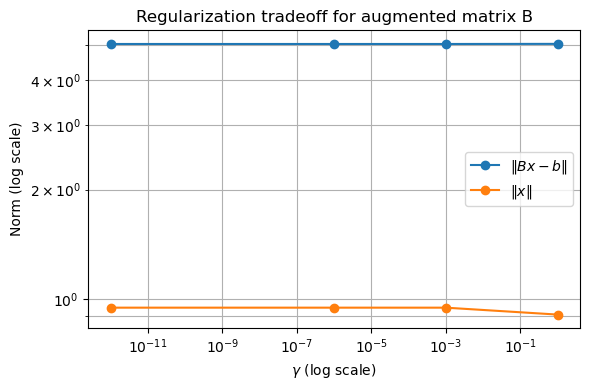

In [27]:

# -- 1. Define original 5x3 A and 5x1 b --
#   A has columns [ (1,2,5,3,-1)^T , (0,3,3,5,6)^T , (1,5,-2,4,3)^T ]
A = np.array([
    [ 1,  0,  1],
    [ 2,  3,  5],
    [ 5,  3, -2],
    [ 3,  5,  4],
    [-1,  6,  3]
], dtype=float)

b = np.array([4, -2, 5, -2, 1], dtype=float)

# -- 2. Form the 5x4 matrix B by adding a column = sum of the original columns --
#      so B[:,3] = A[:,0] + A[:,1] + A[:,2]
B = np.hstack([A, np.sum(A, axis=1, keepdims=True)])

# -- 3. Define the gamma (regularization) values we want to test --
gamma_vals = [1, 1e-3, 1e-6, 1e-12]

# Arrays to store results for plotting
gamma_list = []
res_norm_list = []
sol_norm_list = []

# -- 4. For each gamma, build augmented system and solve --
for gamma in gamma_vals:
    B_aug = np.vstack((B, np.sqrt(gamma) * np.eye(4)))
    b_aug = np.concatenate((b, np.zeros(4)))

    # Solve via least squares (lstsq does the same as “\” in MATLAB)
    x_gamma, residuals, rank, svals = np.linalg.lstsq(B_aug, b_aug, rcond=None)

    # Compute norms
    res_norm = np.linalg.norm(B @ x_gamma - b)
    sol_norm = np.linalg.norm(x_gamma)

    gamma_list.append(gamma)
    res_norm_list.append(res_norm)
    sol_norm_list.append(sol_norm)

# -- 5. Unregularized solution  (gamma=0) --
x_unreg, _, _, _ = np.linalg.lstsq(B, b, rcond=None)
res_unreg = np.linalg.norm(B @ x_unreg - b)
sol_unreg = np.linalg.norm(x_unreg)

# -- 6. SVD‐based “exact” least‐squares solution --
#    (If B is rank‐deficient, you might want to truncate small singular values.)
U, S, Vt = np.linalg.svd(B, full_matrices=False)
# In NumPy’s SVD: B = U * diag(S) * Vt
# So the LS solution is x = V * diag(1/S) * U^T * b
x_svd = Vt.T @ np.diag(1/S) @ (U.T @ b)
res_svd = np.linalg.norm(B @ x_svd - b)
sol_svd = np.linalg.norm(x_svd)

# -- 7. Print out comparison table --
print("Regularized solutions:")
print("  gamma        ||B x - b||      ||x||")
for g, rn, sn in zip(gamma_list, res_norm_list, sol_norm_list):
    print(f"  {g:8.1e}    {rn:12.4e}    {sn:12.4e}")

print("\nUnregularized (gamma=0):")
print(f"  ||B x - b|| = {res_unreg:.4e},   ||x|| = {sol_unreg:.4e}")

print("\nSVD-based least squares:")
print(f"  ||B x - b|| = {res_svd:.4e},   ||x|| = {sol_svd:.4e}")

# -- 8. Plot results of regularization vs. gamma --
plt.figure(figsize=(6,4))
plt.loglog(gamma_list, res_norm_list, 'o-', label=r'$\|Bx - b\|$')
plt.loglog(gamma_list, sol_norm_list, 'o-', label=r'$\|x\|$')
plt.title("Regularization tradeoff for augmented matrix B")
plt.xlabel(r'$\gamma$ (log scale)')
plt.ylabel("Norm (log scale)")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

